## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
!pip install gensim tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

2025-02-03 11:46:21.284843: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 11:46:21.413004: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 11:46:21.484106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738583181.575441    2035 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738583181.598678    2035 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 11:46:21.802980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Exploring the data

In [3]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('../../Distributional_Semantics_Code_Files/aclImdb/train')
test_ds = text_dataset_from_directory('../../Distributional_Semantics_Code_Files/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 75000 files belonging to 3 classes.


2025-02-03 11:46:26.910280: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 25000 files belonging to 2 classes.


2025-02-03 11:46:45.391299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-03 11:46:51.523259: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
28521,"This work is a bold look into the mindset of men who find themselves in wheelchairs. This film never tries to tone it down, cotton candy-ize, or soft soap the angst, confusion, and pain of what th...",1
61187,"I seriously cannot think of why anyone would give this movie a 10/10. Sure we all have different taste in films, but to call this movie perfect is absurd in my opinion. I have nothing against the ...",2
15672,"E! TV is a great channel and Talk Soup is so funny,in a flash you can view the episodes change. We want more funny writings by the best writer ever Stan Evans.. The patron Saint of the mindless ma...",1
60925,"This movie is not great, but it is a good and enjoyable one. It feels like an indie film made out of a play script. Morgan Freeman basically plays himself, although the director swears the script ...",1
63543,This fun little romp into the world of billiards is just as good or better than many films I've seen in all the various video stores and yet I had to schmooze my way into obtaining a screener copy...,2


In [5]:
print(dfTrain.loc[0, 'text'])

If you're a guy you better wear a teflon jockstrap before going to this movie. It is a non stop male bashfest.<br /><br />Wear a fire proof suit to this drivel guys.<br /><br />The acting was bad.<br /><br />The story was ludicrous.<br /><br />Every scene was basically the same.<br /><br />A conversation among several women about how bad men suck.<br /><br />So, if you're feminist or a man hater you will love this gem.<br /><br />Whitney Houston was my favorite plastic statue in this one.<br /><br />I like Hale Berry but she never should have got roped into this.<br /><br />I'd love to have those 90 minutes back of my life.<br /><br />Please.


## Tokenize the text

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153845 unique tokens.


In [7]:
print(train_sequences[0])

[45, 330, 3, 225, 22, 125, 2396, 3, 47364, 87409, 164, 163, 5, 11, 17, 9, 6, 3, 691, 542, 899, 87410, 7, 7, 2396, 3, 1026, 3162, 1954, 5, 11, 3568, 457, 7, 7, 1, 116, 13, 74, 7, 7, 1, 63, 13, 2914, 7, 7, 172, 129, 13, 650, 1, 168, 7, 7, 3, 2434, 780, 434, 360, 41, 88, 74, 335, 2808, 7, 7, 36, 45, 330, 5532, 39, 3, 128, 18314, 22, 82, 112, 11, 1605, 7, 7, 11803, 8240, 13, 59, 523, 3008, 7156, 8, 11, 27, 7, 7, 10, 37, 7335, 6523, 18, 57, 111, 141, 25, 192, 18035, 78, 11, 7, 7, 487, 112, 5, 25, 144, 1524, 230, 140, 4, 59, 115, 7, 7, 594]


In [8]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['if', "you're", 'a', 'guy', 'you', 'better', 'wear', 'a', 'teflon', 'jockstrap', 'before', 'going', 'to', 'this', 'movie', 'it', 'is', 'a', 'non', 'stop', 'male', 'bashfest', 'br', 'br', 'wear', 'a', 'fire', 'proof', 'suit', 'to', 'this', 'drivel', 'guys', 'br', 'br', 'the', 'acting', 'was', 'bad', 'br', 'br', 'the', 'story', 'was', 'ludicrous', 'br', 'br', 'every', 'scene', 'was', 'basically', 'the', 'same', 'br', 'br', 'a', 'conversation', 'among', 'several', 'women', 'about', 'how', 'bad', 'men', 'suck', 'br', 'br', 'so', 'if', "you're", 'feminist', 'or', 'a', 'man', 'hater', 'you', 'will', 'love', 'this', 'gem', 'br', 'br', 'whitney', 'houston', 'was', 'my', 'favorite', 'plastic', 'statue', 'in', 'this', 'one', 'br', 'br', 'i', 'like', 'hale', 'berry', 'but', 'she', 'never', 'should', 'have', 'got', 'roped', 'into', 'this', 'br', 'br', "i'd", 'love', 'to', 'have', 'those', '90', 'minutes', 'back', 'of', 'my', 'life', 'br', 'br', 'please']


In [9]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [10]:
MAX_SEQUENCE_LENGTH

2493

In [11]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [13]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [14]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-03 11:47:11.337702: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-03 11:47:11.398330: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-03 11:47:11.414156: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-03 11:47:11.648605: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.


In [15]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30


2025-02-03 11:47:12.235033: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 747900000 exceeds 10% of free system memory.


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.1668 - loss: -3177.1694 - val_accuracy: 0.5000 - val_loss: 50754.3086
Epoch 2/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.1661 - loss: -106295.6172 - val_accuracy: 0.5000 - val_loss: 356227.2500
Epoch 3/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.1659 - loss: -504480.2500 - val_accuracy: 0.5000 - val_loss: 1019355.4375
Epoch 4/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1635 - loss: -1289127.2500 - val_accuracy: 0.5000 - val_loss: 2089249.8750
Epoch 5/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1669 - loss: -2491455.2500 - val_accuracy: 0.5000 - val_loss: 3621101.0000
Epoch 6/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.1674 - loss: -4149669.2500 - val_accuracy: 0.5000 - val_loss: 5663783.5000
Epoch 7/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.1679 - loss: -6405622.5000 - val_accuracy: 0.5000 - val_loss: 8253658.0000
Epoc

# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [16]:
glove_wiki = KeyedVectors.load_word2vec_format('../../glove.6B.100d.txt', binary=False, no_header=True)

In [17]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])



In [18]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=15
)


Epoch 1/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1674 - loss: -10807.4434 - val_accuracy: 0.5000 - val_loss: 153175.8125
Epoch 2/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1656 - loss: -302602.9062 - val_accuracy: 0.5000 - val_loss: 924432.8125
Epoch 3/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1681 - loss: -1298674.2500 - val_accuracy: 0.5000 - val_loss: 2515776.5000
Epoch 4/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1679 - loss: -3200245.7500 - val_accuracy: 0.5000 - val_loss: 5113431.5000
Epoch 5/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1673 - loss: -6160632.0000 - val_accuracy: 0.5000 - val_loss: 8921684.0000
Epoch 6/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1675 - loss: -10366853.0000 - val_accuracy: 0.5000 - val_loss: 14112006.0000
Epoch 7/15
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1671 - loss: -16248360.0000 - val_accuracy: 0.5000 - val_loss: 2084738

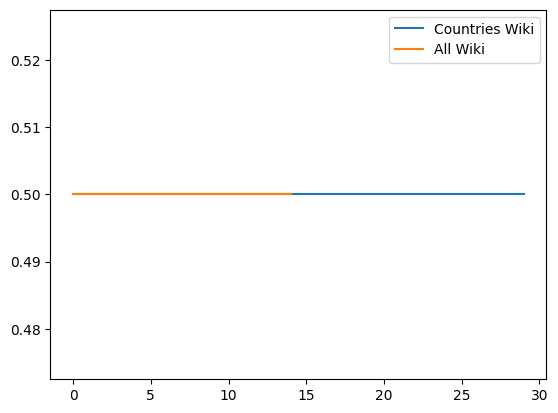

In [19]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()
